# Importation des librairies

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os.path

from sklearn.tree import plot_tree
from sklearn.model_selection import train_eval_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from lifelines.utils import concordance_index



# Modèle MTLR

In [2]:
df_train_scaled = pd.read_csv('data/df_train_scaled.csv')
df_eval_scaled = pd.read_csv('data/df_eval_scaled.csv')

In [3]:
import torch
import torch.nn as nn
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import encode_survival, make_time_bins
import numpy as np
import pandas as pd

X_features = df_train_scaled.drop(columns=['OS_YEARS', 'OS_STATUS'])
X_features = pd.get_dummies(X_features, drop_first=True)
X_features = X_features.astype(float)

X_features_eval = pd.get_dummies(df_eval_scaled, drop_first=True)
X_features_eval = X_features_eval.reindex(columns=X_features.columns, fill_value=0)
X_features_eval = X_features_eval.astype(float)

X_train = torch.tensor(X_features.values, dtype=torch.float32)
X_eval = torch.tensor(X_features_eval.values, dtype=torch.float32)
y_time = torch.tensor(df_train_scaled['OS_YEARS'].values, dtype=torch.float32)
y_event = torch.tensor(df_train_scaled['OS_STATUS'].values, dtype=torch.float32)

# Création des time bins
time_bins = make_time_bins(y_time, event=y_event)
target = encode_survival(y_time, y_event, time_bins)

## Hyperparameter tuning

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 16, 1024, step=16)
    n_hidden2 = trial.suggest_int('n_hidden2', 8, 512, step=8)
    n_layers = trial.suggest_int('n_layers', 2, 4)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.8)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.8)
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 200, 2000, step=50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    use_weight_decay = trial.suggest_categorical('use_weight_decay', [True, False])
    if use_weight_decay:
        weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True)
    else:
        weight_decay = 0.0
    C1 = trial.suggest_float('C1', 0.1, 20.0, log=True)

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        # Re-encode time bins pour chaque fold
        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Modèle dynamique
        layers = [nn.Linear(X_tr_torch.shape[1], n_hidden1), nn.BatchNorm1d(n_hidden1)]
        for i in range(n_layers - 1):
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leakyrelu':
                layers.append(nn.LeakyReLU())
            elif activation == 'elu':
                layers.append(nn.ELU())
            elif activation == 'selu':
                layers.append(nn.SELU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout1 if i == 0 else dropout2))
            if i == 0:
                layers.append(nn.Linear(n_hidden1, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
            else:
                layers.append(nn.Linear(n_hidden2, n_hidden2))
                layers.append(nn.BatchNorm1d(n_hidden2))
        layers.append(MTLR(n_hidden2, len(time_bins)))
        model = nn.Sequential(*layers)

        if optimizer_name == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            if isinstance(result, (tuple, list, np.ndarray)):
                cindex_ipcw = result[0]
            else:
                cindex_ipcw = result.cindex
            scores.append(cindex_ipcw)
        except Exception:
            continue

    if len(scores) == 0:
        return 0.5
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=2)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

[I 2025-09-09 11:04:39,734] A new study created in memory with name: no-name-e7636793-9739-4cb3-bbc9-9cb71b64e7d0
[I 2025-09-09 11:08:56,829] Trial 0 finished with value: 0.6578284754899836 and parameters: {'n_hidden1': 80, 'n_hidden2': 32, 'n_layers': 3, 'dropout1': 0.4454684897195221, 'dropout2': 0.5021509324259708, 'lr': 3.2623204018497886e-05, 'n_epochs': 1600, 'batch_size': 256, 'activation': 'elu', 'optimizer': 'adamw', 'use_weight_decay': False, 'C1': 4.44821546655202}. Best is trial 0 with value: 0.6578284754899836.


In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import numpy as np
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def objective(trial):
    n_hidden1 = trial.suggest_int('n_hidden1', 16, 512, step=16)
    n_hidden2 = trial.suggest_int('n_hidden2', 16, 512, step=16)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.7)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.7)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    n_epochs = trial.suggest_int('n_epochs', 100, 1000, step=50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    activation = trial.suggest_categorical('activation', ['relu', 'leakyrelu', 'elu', 'selu', 'tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd'])
    weight_decay = trial.suggest_float('weight_decay', 1e-7, 1e-2, log=True)
    C1 = trial.suggest_float('C1', 0.1, 10.0, log=True)

    torch.manual_seed(42)
    np.random.seed(42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, df_train_scaled['OS_STATUS'])):
        X_tr, X_val = X_features.iloc[train_idx], X_features.iloc[val_idx]
        y_time_tr, y_time_val = y_time[train_idx], y_time[val_idx]
        y_event_tr, y_event_val = y_event[train_idx], y_event[val_idx]

        time_bins = make_time_bins(y_time_tr, event=y_event_tr)
        target_tr = encode_survival(y_time_tr, y_event_tr, time_bins)

        X_tr_torch = torch.tensor(X_tr.values, dtype=torch.float32)
        X_val_torch = torch.tensor(X_val.values, dtype=torch.float32)

        # Activation dynamique
        if activation == 'relu':
            act_fn = nn.ReLU()
        elif activation == 'leakyrelu':
            act_fn = nn.LeakyReLU()
        elif activation == 'elu':
            act_fn = nn.ELU()
        elif activation == 'selu':
            act_fn = nn.SELU()
        elif activation == 'tanh':
            act_fn = nn.Tanh()
        else:
            act_fn = nn.ReLU()

        layers = [nn.Linear(X_tr_torch.shape[1], n_hidden1), nn.BatchNorm1d(n_hidden1), act_fn, nn.Dropout(dropout1)]
        layers += [nn.Linear(n_hidden1, n_hidden2), nn.BatchNorm1d(n_hidden2), act_fn, nn.Dropout(dropout2)]
        layers += [MTLR(n_hidden2, len(time_bins))]
        model = nn.Sequential(*layers)

        if optimizer_name == 'adamw':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'rmsprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
        elif optimizer_name == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_tr_torch)
            loss = mtlr_neg_log_likelihood(logits, target_tr, model[-1], C1=C1, average=True)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(X_val_torch)
            surv_val = mtlr_survival(logits_val)
        median_pred = []
        for surv in surv_val:
            below_half = np.where(surv.numpy() <= 0.5)[0]
            if below_half.size > 0 and below_half[0] < len(time_bins):
                median_pred.append(time_bins[below_half[0]].item())
            else:
                median_pred.append(time_bins[-1].item())

        if (y_event_val == 1).sum() == 0 or (y_event_val == 0).sum() == 0:
            continue

        y_train_struct = Surv.from_arrays(event=to_numpy(y_event_tr).astype(bool), time=to_numpy(y_time_tr))
        y_val_struct = Surv.from_arrays(event=to_numpy(y_event_val).astype(bool), time=to_numpy(y_time_val))
        try:
            result = concordance_index_ipcw(
                y_train_struct,
                y_val_struct,
                -np.array(median_pred)
            )
            cindex_ipcw = result[0] if isinstance(result, (tuple, list, np.ndarray)) else result.cindex
            scores.append(cindex_ipcw)
        except Exception:
            continue

    if len(scores) == 0:
        return 0.5
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000, n_jobs=3)

print("Best trial:")
print(study.best_trial)
print("Best params:", study.best_params)

[I 2025-09-08 23:02:30,065] A new study created in memory with name: no-name-68d18d55-af17-4b1c-baa4-3be13fc3149f
[I 2025-09-08 23:04:57,453] Trial 2 finished with value: 0.5 and parameters: {'n_hidden1': 400, 'n_hidden2': 336, 'dropout1': 0.4728315760491939, 'dropout2': 0.6808722335574927, 'lr': 6.941172401221325e-05, 'n_epochs': 300, 'batch_size': 64, 'activation': 'tanh', 'optimizer': 'rmsprop', 'weight_decay': 2.8022030081135215e-05, 'C1': 0.43455861414718105}. Best is trial 2 with value: 0.5.
[I 2025-09-08 23:08:06,760] Trial 0 finished with value: 0.5 and parameters: {'n_hidden1': 96, 'n_hidden2': 448, 'dropout1': 0.16540998673664783, 'dropout2': 0.6702644797090611, 'lr': 0.008953114786810257, 'n_epochs': 900, 'batch_size': 256, 'activation': 'selu', 'optimizer': 'adamw', 'weight_decay': 0.008786801357825542, 'C1': 2.4517895273729065}. Best is trial 2 with value: 0.5.
[I 2025-09-08 23:08:21,096] Trial 1 finished with value: 0.5 and parameters: {'n_hidden1': 496, 'n_hidden2': 80, 

In [ ]:
import json

with open("best_params.txt", "w") as f:
    f.write(json.dumps(study.best_params, indent=4))

In [4]:
best_params= {
    "n_hidden1": 30,
    "n_hidden2": 207,
    "dropout1": 0.5897436562793472,
    "dropout2": 0.07156895220993648,
    "lr": 0.000970336817396098,
    "n_epochs": 143,
    "batch_size": 128,
    "optimizer": "adamw",
    "C1": 1.443457890047099
}

## Training

In [8]:
# Utilisation des meilleurs paramètres trouvés par Optuna
n_hidden1 = best_params['n_hidden1']
n_hidden2 = best_params['n_hidden2']
dropout1 = best_params['dropout1']
dropout2 = best_params['dropout2']
lr = best_params['lr']
n_epochs = best_params['n_epochs']
batch_size = best_params.get('batch_size', 128)
optimizer_name = best_params.get('optimizer', 'adam')
C1 = best_params.get('C1', 1.0)
activation = best_params.get('activation', 'relu')
weight_decay = best_params.get('weight_decay', 0.0)  # ou 'use_weight_decay' selon le paramètre Optuna

# Sélection dynamique de l'activation
if activation == 'relu':
    act_fn = nn.ReLU()
elif activation == 'leakyrelu':
    act_fn = nn.LeakyReLU()
elif activation == 'elu':
    act_fn = nn.ELU()
elif activation == 'selu':
    act_fn = nn.SELU()
elif activation == 'tanh':
    act_fn = nn.Tanh()
else:
    raise ValueError(f"Activation inconnue: {activation}")

model = nn.Sequential(
    nn.Linear(X_train.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    act_fn,
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    act_fn,
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

# Sélection dynamique de l'optimizer
if optimizer_name == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'rmsprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Entraînement
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = mtlr_neg_log_likelihood(logits, target, model[-1], C1=C1, average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

Epoch 10/143 - Loss: 44.0194
Epoch 20/143 - Loss: 37.0726
Epoch 30/143 - Loss: 31.3448
Epoch 40/143 - Loss: 26.5829
Epoch 50/143 - Loss: 22.6105
Epoch 60/143 - Loss: 19.2605
Epoch 70/143 - Loss: 16.5152
Epoch 80/143 - Loss: 14.2145
Epoch 90/143 - Loss: 12.3040
Epoch 100/143 - Loss: 10.6817
Epoch 110/143 - Loss: 9.3222
Epoch 120/143 - Loss: 8.1932
Epoch 130/143 - Loss: 7.2538
Epoch 140/143 - Loss: 6.4430


## Inference

In [10]:
from sklearn.model_selection import train_test_split

# Split features and targets
X_train_split, X_test_split, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X_features, y_time, y_event, 
    test_size=0.2,
    random_state=42,
    stratify=df_train_scaled['OS_STATUS']  # Stratify on the event status to maintain similar censoring proportions
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_split.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_split.values, dtype=torch.float32)

# Create time bins and encode survival for training data
time_bins = make_time_bins(y_time_train, event=y_event_train)
target_train = encode_survival(y_time_train, y_event_train, time_bins)

print(f"Training set size: {len(X_train_split)}")
print(f"Test set size: {len(X_test_split)}")
print(f"Number of features: {X_train_split.shape[1]}")

Training set size: 2538
Test set size: 635
Number of features: 254


In [16]:
# Training
time_bins = make_time_bins(y_time_train, event=y_event_train)
target_train = encode_survival(y_time_train, y_event_train, time_bins)

# Initialize model with best parameters
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], n_hidden1),
    nn.BatchNorm1d(n_hidden1),
    nn.ReLU(),
    nn.Dropout(dropout1),
    nn.Linear(n_hidden1, n_hidden2),
    nn.BatchNorm1d(n_hidden2),
    nn.ReLU(),
    nn.Dropout(dropout2),
    MTLR(n_hidden2, len(time_bins))
)

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Training loop
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train_tensor)
    loss = mtlr_neg_log_likelihood(logits, target_train, model[-1], C1=C1, average=True)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss.item():.4f}")

# Inference on test set
model.eval()
with torch.no_grad():
    logits_test = model(X_test_tensor)
    surv_test = mtlr_survival(logits_test)
    median_pred_test = []
    for surv in surv_test:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_test.append(time_bins[below_half[0]].item())
        else:
            median_pred_test.append(time_bins[-1].item())

# Calculate C-index
y_train_struct = Surv.from_arrays(event=to_numpy(y_event_train).astype(bool), time=to_numpy(y_time_train))
# Find the maximum observed time in the training set
max_train_time = to_numpy(y_time_train).max()

# Filter test samples to only those with time <= max_train_time
valid_idx = to_numpy(y_time_test) <= max_train_time

# Filter all relevant arrays
y_test_struct_valid = Surv.from_arrays(
    event=to_numpy(y_event_test)[valid_idx].astype(bool),
    time=to_numpy(y_time_test)[valid_idx]
)
median_pred_test_valid = np.array(median_pred_test)[valid_idx]

# Now compute IPCW C-index
result = concordance_index_ipcw(
    y_train_struct,
    y_test_struct_valid,
    -median_pred_test_valid
)
cindex_ipcw = result[0] if isinstance(result, (tuple, list, np.ndarray)) else result.cindex

print(f"\nC-index IPCW on test set: {cindex_ipcw:.4f}")

Epoch 10/143 - Loss: 40.3855
Epoch 20/143 - Loss: 34.1441
Epoch 30/143 - Loss: 29.0141
Epoch 40/143 - Loss: 24.7057
Epoch 50/143 - Loss: 21.1342
Epoch 60/143 - Loss: 18.1101
Epoch 70/143 - Loss: 15.6216
Epoch 80/143 - Loss: 13.5084
Epoch 90/143 - Loss: 11.7381
Epoch 100/143 - Loss: 10.2530
Epoch 110/143 - Loss: 9.0001
Epoch 120/143 - Loss: 7.9426
Epoch 130/143 - Loss: 7.0570
Epoch 140/143 - Loss: 6.2979

C-index IPCW on test set: 0.6993


In [ ]:
# Prépare les features eval (déjà fait dans ton code)
X_eval_torch = torch.tensor(X_features_eval.values, dtype=torch.float32)

# Prédiction
model.eval()
with torch.no_grad():
    logits_eval = model(X_eval_torch)
    surv_eval = mtlr_survival(logits_eval)
    median_pred_eval = []
    for surv in surv_eval:
        below_half = np.where(surv.numpy() <= 0.5)[0]
        if below_half.size > 0 and below_half[0] < len(time_bins):
            median_pred_eval.append(time_bins[below_half[0]].item())
        else:
            median_pred_eval.append(time_bins[-1].item())

# Soumission
risk_score_eval = -np.array(median_pred_eval)
submission = pd.DataFrame({
    "ID": test_scaled['ID'],
    "risk_score": risk_score_eval
})
submission.to_csv("submission_mtlr.csv", index=False)

NameError: name 'ID_eval' is not defined

## SHAP Feature importance

In [23]:
min_risk = submission['risk_score'].min()
max_risk = submission['risk_score'].max()
print("Minimum risk :", min_risk)
print("Maximum risk :", max_risk)

Minimum risk : -7.443835735321045
Maximum risk : -0.20821918547153473


Temps cible 12 → intervalle index 8 (≈ 12.0)


  0%|          | 0/20 [00:00<?, ?it/s]

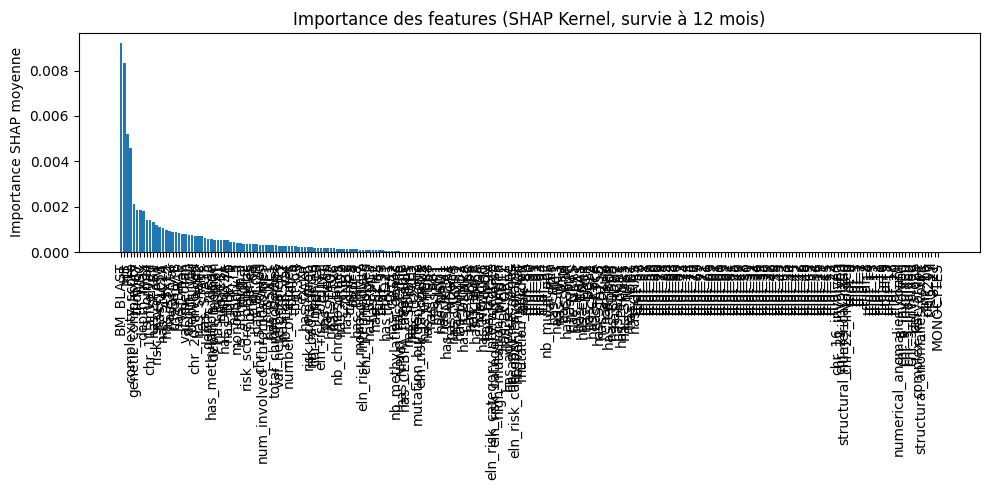

In [ ]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# ⚙️ Paramètres
T_max = 60
n_intervals = 41
t_target = 12

time_grid = np.linspace(0, T_max, n_intervals)
time_idx = np.argmin(np.abs(time_grid - t_target))

print(f"Temps cible {t_target} → intervalle index {time_idx} (≈ {time_grid[time_idx]:.1f})")

background_np = X_features.iloc[:100].values
eval_sample_np = X_features.iloc[100:120].values
features = np.array(X_features.columns)

model.eval()

# Fonction prédictive pour SHAP : proba de survie à t_target
def predict_fn(x_numpy):
    x_torch = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_torch)  # (batch_size, n_intervals)
        surv = mtlr_survival(logits)  # (batch_size, n_intervals), valeurs entre 0 et 1
        y_target = surv[:, time_idx].numpy()  # proba de survie à t_target
    return y_target

explainer = shap.KernelExplainer(predict_fn, background_np)

# Valeurs SHAP
shap_values = explainer.shap_values(eval_sample_np, nsamples=100)

feature_importance = np.mean(np.abs(shap_values), axis=0)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(features[sorted_idx], feature_importance[sorted_idx])
plt.xticks(rotation=90)
plt.title(f"Importance des features (SHAP Kernel, survie à {t_target} mois)")
plt.ylabel("Importance SHAP moyenne")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd

# Création du tableau d'importance trié
shap_df = pd.DataFrame({
    "feature": features[sorted_idx],
    "importance": feature_importance[sorted_idx]
}).reset_index(drop=True)

# Affichage markdown pour LLM
print("\nTableau markdown pour LLM :\n")
print(shap_df.to_markdown(index=False))


Tableau markdown pour LLM :

| feature                        |   importance |
|:-------------------------------|-------------:|
| BM_BLAST                       |  0.00920469  |
| HB                             |  0.0083339   |
| PLT                            |  0.00521865  |
| complexity_score               |  0.00458192  |
| genetic_complexity             |  0.00213011  |
| tfidf_67                       |  0.00186794  |
| WBC                            |  0.00186487  |
| depth_max                      |  0.00178917  |
| is_normal                      |  0.00140275  |
| chr_11_involved                |  0.00140031  |
| has_SF3B1                      |  0.00132728  |
| risk_score_raw                 |  0.00119719  |
| has_TP53                       |  0.00112187  |
| has_SMC1A                      |  0.00107861  |
| has_ASXL2                      |  0.000979784 |
| has_TET2                       |  0.000928693 |
| vaf_var                        |  0.00089599  |
| trisomy_8         